## How do RFs evolve through the Fine Tuning process?

In this case we will be visualizing the changes produced in the receptive fields of selected units during the transfer process. 

_This experiment assumes that the snapshots from training the `e2` model have been stored in Emotion6/.results . If not, you must re-train this models before continuing_.  

#### Setup

In [3]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (5,5)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
# We added it to PYTHONPATH (e.g. from ~/.bash_profile)

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [4]:
def get_transformer(net):
    # load the mean places image 
    mu = np.load('Emotion6/places205CNN_mean.npy')
    mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
    
    # create transformer for the input called 'data'
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

    transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
    transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
    transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
    transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
    return transformer

In [5]:
caffe.set_mode_gpu()

def get_model(model_definition, model_weights):
    net = caffe.Net(model_definition,
                    model_weights,
                    caffe.TEST)
    return net

In [10]:
def generate_circle_mask(array, a, b, r):
    n = array.shape[0]
    y,x = np.ogrid[-a:n-a, -b:n-b]
    mask = x*x + y*y <= r*r
    array[mask] = 1
    return array

def inner_image(img):
    minsize = np.min(img.shape[:2])
    x0 = (img.shape[0]-minsize)/2
    y0 = (img.shape[1]-minsize)/2
    return img[x0:x0+minsize, y0:y0+minsize,:]

def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')
    plt.show()

# this method shows the RF of a given unit 
def show_RF(image, model, layer_id, units, kernel_size = 30):    #feedworward the net
    transformer = get_transformer(model)
    model.blobs['data'].data[...] = transformer.preprocess('data', image)
    model.forward()
    vis_square(model.blobs[layer_id].data[0,:])  
    

In [11]:
# data
test_image = caffe.io.load_image('../databases/Emotion6/images/joy/13.jpg')
model_root = 'Emotion6/.results/e2.finetune_emotion6_iter_%i.caffemodel'

Model for 10000 iterations


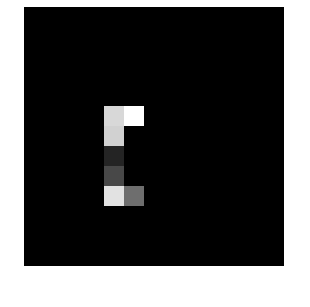

Model for 20000 iterations


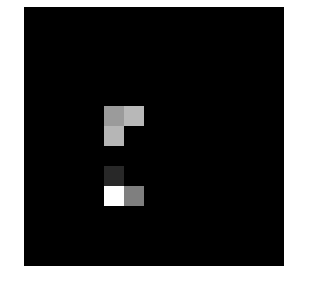

Model for 30000 iterations


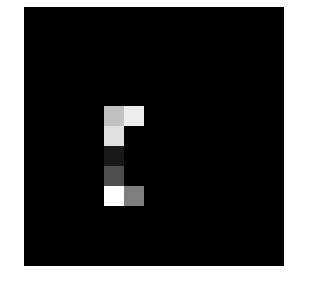

Model for 40000 iterations


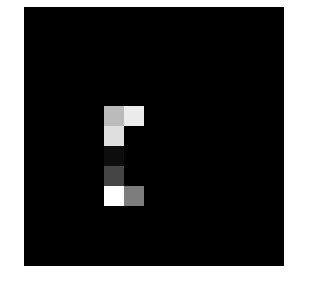

Model for 50000 iterations


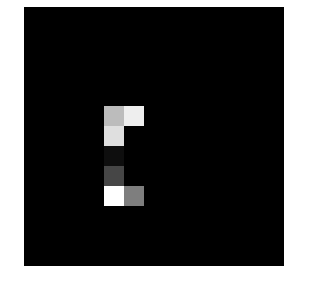

Model for 60000 iterations


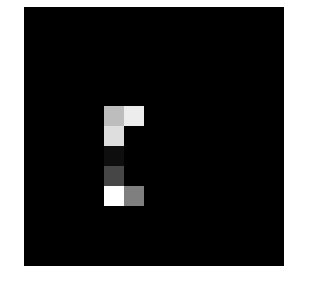

Model for 70000 iterations


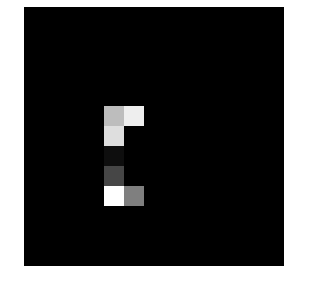

Model for 80000 iterations


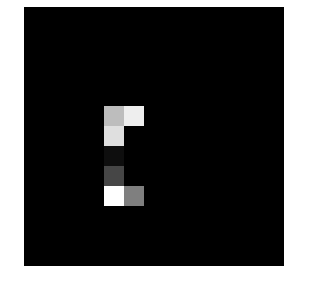

Model for 90000 iterations


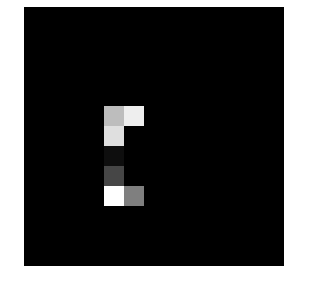

Model for 100000 iterations


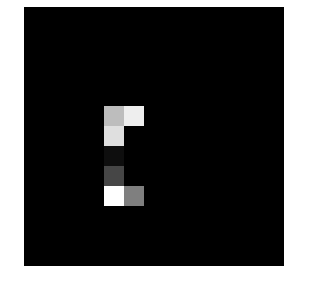

In [12]:
for iters in range(10000,100000+1,10000):
    model_file = model_root % iters
    print 'Model for %i iterations' % iters
    model = get_model('Emotion6/e2.deploy.prototxt', model_file)
    show_RF(test_image, model, 'conv5', 0 )

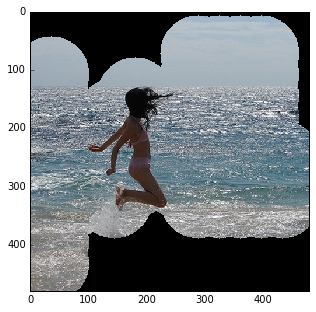

In [15]:
model = get_model('Emotion6/e2.deploy.prototxt', 'Emotion6/e2.caffemodel')
show_RF(test_image, model, 'conv4', 10, 65)